# Spotify Song Popularity Prediction

# K Karthik Raj

This notebook aims to predict the popularity of Spotify songs based on various audio features and metadata. We will explore different regression models, preprocess the data, and evaluate their performance.

## 1. Data Loading and Initial Exploration

We begin by loading the dataset into a pandas DataFrame and examining its structure and initial rows using the `.head()` method. This step is crucial to understand the available data, identify potential issues like missing values, and get a general sense of the features we'll be working with. We also import necessary libraries for data manipulation, modeling, and visualization.

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load Dataset
data = pd.read_csv('/content/Spotify_data.csv')

## 2. Feature Engineering

To enhance our model's predictive power, we create new features from existing ones. We convert the 'Release Date' column to datetime objects to extract the year, month, and day as separate numerical features. Additionally, we calculate the duration of each song in seconds from milliseconds and create features representing the number of artists collaborating on a track and the length of the album name. These new features can potentially capture valuable patterns related to song popularity.

In [14]:
data['Release Date'] = pd.to_datetime(data['Release Date'])
data['release_year'] = data['Release Date'].dt.year
data['release_month'] = data['Release Date'].dt.month
data['release_day'] = data['Release Date'].dt.day
data['duration_seconds'] = data['Duration (ms)'] / 1000

In [15]:
data['num_artists'] = data['Artists'].apply(lambda x: len(x.split(',')))
data['album_name_length'] = data['Album Name'].apply(lambda x: len(x))

In [16]:
display(data.head())

,Unnamed: 0,Track Name,Artists,Album Name,Album ID,Track ID,Popularity,Release Date,Duration (ms),Explicit,...,Instrumentalness,Liveness,Valence,Tempo,release_year,release_month,release_day,duration_seconds,num_artists,album_name_length
0,0,Not Like Us,Kendrick Lamar,Not Like Us,5JjnoGJyOxfSZUZtk2rRwZ,6AI3ezQ4o3HUoP6Dhudph3,96,2024-05-04,274192,True,...,0.000000,0.1410,0.214,101.061,2024,5,4,274.192,1,11
1,1,Houdini,Eminem,Houdini,6Xuu2z00jxRPZei4IJ9neK,2HYFX63wP3otVIvopRS99Z,94,2024-05-31,227239,True,...,0.000002,0.0582,0.889,127.003,2024,5,31,227.239,1,7
2,2,BAND4BAND (feat. Lil Baby),"Central Cee, Lil Baby",BAND4BAND (feat. Lil Baby),4AzPr5SUpNF553eC1d3aRy,7iabz12vAuVQYyekFIWJxD,91,2024-05-23,140733,True,...,0.000000,0.1190,0.886,140.113,2024,5,23,140.733,2,26
3,3,I Don't Wanna Wait,"David Guetta, OneRepublic",I Don't Wanna Wait,0wCLHkBRKcndhMQQpeo8Ji,331l3xABO0HMr1Kkyh2LZq,90,2024-04-05,149668,False,...,0.000000,0.2320,0.554,129.976,2024,4,5,149.668,2,18
4,4,Pedro,"Jaxomy, Agatino Romero, Raffaella Carrà",Pedro,5y6RXjI5VPR0RyInghTbf1,48lxT5qJF0yYyf2z4wB4xW,89,2024-03-29,144846,False,...,0.000001,0.3110,0.844,151.019,2024,3,29,144.846,3,5


## 3. Data Preprocessing

Before training our models, we need to preprocess the data to handle missing values and scale numerical features.
- **Handling Missing Values:** We fill any missing numerical values using the median of their respective columns. This is a common strategy to prevent missing data from causing errors or biasing the model.
- **Feature Identification:** We explicitly define the categorical and numerical features that will be used in our models. In this case, we are focusing on numerical features.
- **Scaling Numerical Features:** We use `StandardScaler` within a `Pipeline` to standardize the numerical features. This transforms the data such that each feature has a mean of 0 and a standard deviation of 1, which is important for many machine learning algorithms.
- **Column Transformer:** We use `ColumnTransformer` to apply the defined preprocessing steps to the appropriate columns. This ensures that only numerical features are scaled.
- **Data Splitting:** We split the data into training and testing sets using `train_test_split` to evaluate the model's performance on unseen data. The target variable is 'Popularity'.
- **Applying Preprocessing:** The preprocessor is fitted on the training data and then used to transform both the training and testing sets.

In [17]:
def preprocess_data(data):
    # Handle missing values
    data.fillna(data.median(numeric_only=True), inplace=True)

    # Identify categorical and numerical features
    categorical_features = []  # Removed 'artists' and 'album_name'
    numerical_features = ['acousticness', 'danceability', 'energy', 'instrumentalness',
                          'liveness', 'loudness', 'speechiness', 'tempo', 'valence',
                          'release_year', 'release_month', 'release_day', 'duration_seconds',
                          'num_artists', 'album_name_length'] # Added new numerical features

    # Define transformers
    num_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    # Only include categorical transformer if there are categorical features
    if categorical_features:
        cat_transformer = Pipeline(steps=[
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])
        transformers = [('num', num_transformer, numerical_features),
                        ('cat', cat_transformer, categorical_features)]
    else:
        transformers = [('num', num_transformer, numerical_features)]

    # Combine transformers into a preprocessor
    preprocessor = ColumnTransformer(
        transformers=transformers)

    return preprocessor

target = 'Popularity' # Define target before calling the function
preprocessor = preprocess_data(data.drop(columns=[target])) # Apply preprocessing to X

In [18]:
# Data Preprocessing - Define preprocessor structure
categorical_features = []
numerical_features = ['Acousticness', 'Danceability', 'Energy', 'Instrumentalness',
                      'Liveness', 'Loudness', 'Speechiness', 'Tempo', 'Valence',
                      'release_year', 'release_month', 'release_day', 'duration_seconds',
                      'num_artists', 'album_name_length']

# Define transformers
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Combine transformers into a preprocessor
# Only include categorical transformer if there are categorical features
if categorical_features:
    cat_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    preprocessor = ColumnTransformer(
        transformers=[('num', num_transformer, numerical_features),
                      ('cat', cat_transformer, categorical_features)],
        remainder='passthrough'
    )
else:
    preprocessor = ColumnTransformer(
        transformers=[('num', num_transformer, numerical_features)],
        remainder='passthrough'
    )


# Splitting Data
target = 'Popularity'
X = data.drop(columns=[target])
y = data[target]

# Handle missing values before splitting
X.fillna(X.median(numeric_only=True), inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Select only the columns relevant to the preprocessor
X_train_for_preprocessing = X_train[numerical_features + categorical_features]
X_test_for_preprocessing = X_test[numerical_features + categorical_features]


# Apply preprocessing to the data
X_train_processed = preprocessor.fit_transform(X_train_for_preprocessing)
X_test_processed = preprocessor.transform(X_test_for_preprocessing)


## 4. Model Selection and Training

We select and train several regression models to predict song popularity. The models chosen are:
- **Linear Regression:** A basic linear model that predicts the target variable as a linear combination of the features.
- **Ridge Regression:** A linear model that includes L2 regularization to prevent overfitting.
- **Lasso Regression:** A linear model that includes L1 regularization, which can lead to sparse models by setting some coefficients to zero.
- **Random Forest Regressor:** An ensemble learning method that builds multiple decision trees and combines their predictions to improve accuracy and reduce overfitting.

We train each model on the preprocessed training data and then evaluate their performance on the preprocessed test data using two common regression metrics:
- **Mean Squared Error (MSE):** Measures the average of the squared differences between the predicted and actual values. Lower MSE indicates better performance.
- **R-squared (R^2):** Represents the proportion of the variance in the target variable that is predictable from the features. A higher R^2 indicates a better fit.

In [19]:
# Model Selection and Training
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train_processed, y_train)

    y_pred = model.predict(X_test_processed)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[name] = {'MSE': mse, 'R^2': r2}
    print(f"{name}: MSE={mse}, R^2={r2}")

Linear Regression: MSE=69.60362025030564, R^2=-0.045734595637934694
Ridge Regression: MSE=69.51225292296695, R^2=-0.04436188004116781
Lasso Regression: MSE=53.950322577900394, R^2=0.1894427536577873
Random Forest: MSE=42.09248043478262, R^2=0.3675966444191989


## 5. Hyperparameter Tuning

To optimize the performance of our best-performing model (Random Forest), we perform hyperparameter tuning using `GridSearchCV`. Hyperparameters are parameters that are not learned from the data but are set prior to training. `GridSearchCV` systematically searches through a predefined grid of hyperparameter values, training and evaluating the model with each combination using cross-validation. This helps us find the optimal set of hyperparameters that maximize the model's performance (in this case, measured by the R^2 score). The `param_grid` variable defines the range of hyperparameters to search over for the `RandomForestRegressor`.

In [20]:
# Hyperparameter Tuning for Random Forest
rf = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='r2')
grid_search.fit(X_train_processed, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best R^2 Score: {grid_search.best_score_}")

Best parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}
Best R^2 Score: 0.1123016249722695


## 6. Final Model Evaluation

After identifying the best hyperparameters through GridSearchCV, we train the final Random Forest model using these optimal parameters on the entire training dataset. We then evaluate this final model on the held-out test set to obtain an unbiased estimate of its performance in terms of MSE and R^2 score. This final evaluation provides a realistic measure of how well the model is expected to perform on new, unseen data.

In [21]:
# Final Model Evaluation
final_model = grid_search.best_estimator_
final_model.fit(X_train_processed, y_train)
final_predictions = final_model.predict(X_test_processed)

final_mse = mean_squared_error(y_test, final_predictions)
final_r2 = r2_score(y_test, final_predictions)

print(f"Final Model Performance: MSE={final_mse}, R^2={final_r2}")

Final Model Performance: MSE=48.16621076428548, R^2=0.2763440643479971


## 7. Visualize Model Performance

Finally, we visualize the performance of all the models using bar plots to compare their MSE and R^2 scores. We create a pandas DataFrame from the `results` dictionary to easily plot the scores for each model. Two subplots are generated: one for R^2 scores and one for MSE scores. Bar plots provide a clear visual comparison of how each model performed on the task, allowing us to easily identify the best-performing models based on these metrics. A higher R^2 and lower MSE indicate better model performance.

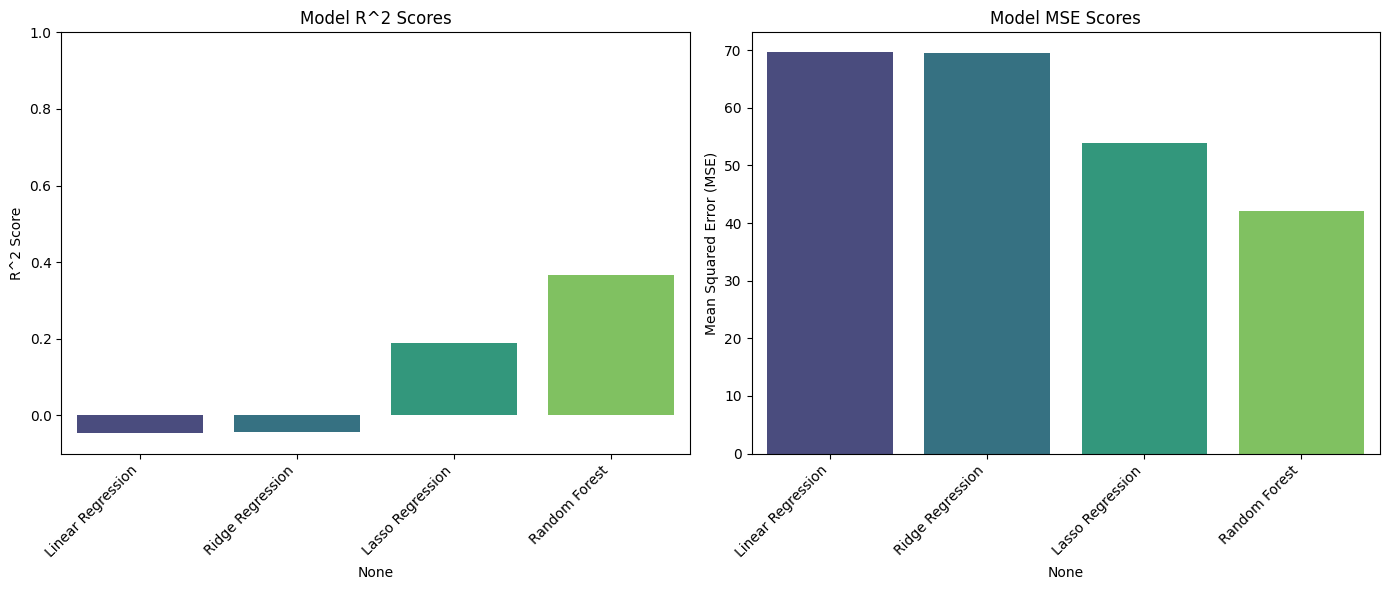

In [22]:
# Visualize Results with both MSE and R^2
results_df = pd.DataFrame(results).T

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot R^2 scores
sns.barplot(x=results_df.index, y=results_df['R^2'], ax=axes[0], palette='viridis', hue=results_df.index, legend=False)
axes[0].set_xticks(range(len(results_df.index))) # Set tick locations
axes[0].set_xticklabels(results_df.index, rotation=45, ha='right')
axes[0].set_ylabel('R^2 Score')
axes[0].set_title('Model R^2 Scores')
axes[0].set_ylim([-0.1, 1]) # Set y-limit to better visualize negative R^2
axes[0].tick_params(axis='x', labelbottom=True) # Ensure labels are visible

# Plot MSE scores
sns.barplot(x=results_df.index, y=results_df['MSE'], ax=axes[1], palette='viridis', hue=results_df.index, legend=False)
axes[1].set_xticks(range(len(results_df.index))) # Set tick locations
axes[1].set_xticklabels(results_df.index, rotation=45, ha='right')
axes[1].set_ylabel('Mean Squared Error (MSE)')
axes[1].set_title('Model MSE Scores')
axes[1].tick_params(axis='x', labelbottom=True) # Ensure labels are visible


plt.tight_layout()
plt.show()